<h3 style="color:RED">Importing the required modules</h3>

In [1]:
import sys
import numpy as np
import pandas as pd
import argparse
from sklearn import metrics
from sklearn.model_selection import train_test_split
from random import shuffle

In [2]:
import tensorflow as tf
import sklearn as sk
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

2023-10-18 17:06:49.908813: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 17:06:58.033389: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 17:06:58.033470: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 17:06:58.066352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 17:06:59.415104: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 17:06:59.419206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

<h3 style ="color : Red">Add ArgumentParser</h3>

In [3]:
parser = argparse.ArgumentParser()

<h4 style = "color : red"> Adding the argparse for dataset</h4>

In [4]:
parser.add_argument(
    '-D',
    '--dataset_file',
    help='File containing data for training',
    type=str,
    required=True,
    default="dataset_more_lables.dat",
)

_StoreAction(option_strings=['-D', '--dataset_file'], dest='dataset_file', nargs=None, const=None, default='dataset_more_lables.dat', type=<class 'str'>, choices=None, required=True, help='File containing data for training', metavar=None)

<h4 style = "color:RED"> Adding the argparse for Max Letters</h4>

In [5]:
parser.add_argument(
    '-M',
    '--max_letters',
    help='Max sequence length',
    type=int,
    required=False,
    default=500,
)

_StoreAction(option_strings=['-M', '--max_letters'], dest='max_letters', nargs=None, const=None, default=500, type=<class 'int'>, choices=None, required=False, help='Max sequence length', metavar=None)

<h4 style = "color:RED"> Adding the argparse for Min Letters</h4>

In [6]:
parser.add_argument(
    '-m',
    '--min_letters',
    help='Min sequence length',
    type=int,
    required=False,
    default=5,
)

_StoreAction(option_strings=['-m', '--min_letters'], dest='min_letters', nargs=None, const=None, default=5, type=<class 'int'>, choices=None, required=False, help='Min sequence length', metavar=None)

<h4 style = "color:RED"> Adding the argparse for Verbosity</h4>

In [7]:
parser.add_argument(
    '-v',
    '--verbose',
    help='Level of verbosity',
    type=bool,
    required=False,
    default=False,
)

_StoreAction(option_strings=['-v', '--verbose'], dest='verbose', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, required=False, help='Level of verbosity', metavar=None)

<h4 style = "color:RED"> Adding the argparse for Size of the minibatch</h4>

In [8]:
parser.add_argument(
    '-b',
    '--batch_size',
    help='Size of the minibatch',
    type=int,
    required=False,
    default=100,
)

_StoreAction(option_strings=['-b', '--batch_size'], dest='batch_size', nargs=None, const=None, default=100, type=<class 'int'>, choices=None, required=False, help='Size of the minibatch', metavar=None)

<h4 style = "color:RED"> Adding the argparse for Number of epochs in training</h4>

In [9]:
parser.add_argument(
    '-e',
    '--epochs',
    help='Number of epochs in training',
    type=int,
    required=False,
    default=200,
)

_StoreAction(option_strings=['-e', '--epochs'], dest='epochs', nargs=None, const=None, default=200, type=<class 'int'>, choices=None, required=False, help='Number of epochs in training', metavar=None)

<h4 style = "color:RED"> Adding the argparse for Where to store the train model</h4>

In [10]:
parser.add_argument(
    '-S',
    '--Save_file',
    help='Where to store the train model',
    type=str,
    required=False,
)

_StoreAction(option_strings=['-S', '--Save_file'], dest='Save_file', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=False, help='Where to store the train model', metavar=None)

In [11]:
args = parser.parse_args(["-D", "dataset_more_labels.dat", "-M", "500", "-m", "5", "-v","True", "-b", "100", "-e", "200", "-S", "model.h5"])

In [12]:
if args.verbose:
    print(f'Numpy: {np.__version__}')
    print(f'TensorFlow: {tf.__version__}')
    print(f'Pandas: {pd.__version__}')
    print(f'Sklearn: {sk.__version__}')


Numpy: 1.24.3
TensorFlow: 2.14.0
Pandas: 2.0.3
Sklearn: 1.3.0


<h3 style='color:Red'> Reading Dataset</h3>

In [13]:
f = lambda x: x[: args.max_letters]
with open(args.dataset_file, 'rb') as csvfile:
    df = pd.read_csv(
        csvfile,
        delimiter='|',
        names=['note', 'label', 'model_id', 'state'],
        skipinitialspace=True,
        converters={'state': f},
    )

In [14]:
if args.verbose:
    df.describe()

In [15]:
df.dropna(axis=0, how='any', inplace=True)
df.drop(axis=1, columns=['note', 'model_id'], inplace=True)

In [16]:
indexNames = df[df['state'].str.len() < args.min_letters].index
df.drop(indexNames, inplace=True)

In [17]:
df.loc[df.label.str.contains('Normal'), 'label'] = 'Normal'
df.loc[df.label.str.contains('Botnet'), 'label'] = 'Malicious'
df.loc[df.label.str.contains('Malware'), 'label'] = 'Malicious'

<h4 style="color:red"> Lableing the data 

In [18]:
df.label.replace('Malicious', 1, inplace=True)
df.label.replace('Normal', 0, inplace=True)
print(df['state'])

0     55.v.e.e.E.v.e.E.v.E.E.v.v.e.v.v.e.e.e.e.v.v.e...
1     22,b,b,S*S,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b...
2     11*R,R.r.R.r.r.r.R.r.r.r.r.v.v.B.B.r.A.r.A.R.R...
3     11.0000000000000000000000000000000000000000000...
4     12*S+b+b+b+a+b+b+a+a+a+00RR+A+00000000000SS+b+...
                            ...                        
58                              11*00000000000000S0000r
60                      11*R,r,R+a+R.R.R.R,a,a,r+A+a+a+
63                        11.R,R.R,R.R,R.R.R.R.R.R.R.R.
64    44.v.U+U.d.u.V.V.V.D.V.U.u.u.U.V+d+U.V.U+U,U.U...
65                                          55*V.R,0RV*
Name: state, Length: 62, dtype: object


<h3 style='color:Red'>Convert each of the stratosphere letters to an integer. There are 50</h3>

In [19]:
vocabulary = list('abcdefghiABCDEFGHIrstuvwxyzRSTUVWXYZ1234567890,.+*')
int_of_letters = {}
for i, letter in enumerate(vocabulary):
    int_of_letters[letter] = float(i)
print(int_of_letters)
if args.verbose:
    print(
        f'There are {len(int_of_letters)} letters in total. From letter index {min(int_of_letters.values())} to letter index {max(int_of_letters.values())}.'
    )
vocabulary_size = len(int_of_letters)

{'a': 0.0, 'b': 1.0, 'c': 2.0, 'd': 3.0, 'e': 4.0, 'f': 5.0, 'g': 6.0, 'h': 7.0, 'i': 8.0, 'A': 9.0, 'B': 10.0, 'C': 11.0, 'D': 12.0, 'E': 13.0, 'F': 14.0, 'G': 15.0, 'H': 16.0, 'I': 17.0, 'r': 18.0, 's': 19.0, 't': 20.0, 'u': 21.0, 'v': 22.0, 'w': 23.0, 'x': 24.0, 'y': 25.0, 'z': 26.0, 'R': 27.0, 'S': 28.0, 'T': 29.0, 'U': 30.0, 'V': 31.0, 'W': 32.0, 'X': 33.0, 'Y': 34.0, 'Z': 35.0, '1': 36.0, '2': 37.0, '3': 38.0, '4': 39.0, '5': 40.0, '6': 41.0, '7': 42.0, '8': 43.0, '9': 44.0, '0': 45.0, ',': 46.0, '.': 47.0, '+': 48.0, '*': 49.0}
There are 50 letters in total. From letter index 0.0 to letter index 49.0.


In [20]:
# Change the letters in the state to an integer representing it uniquely. We 'encode' them.
print(df['state'])
df['state'] = df['state'].apply(lambda x: [[int_of_letters[i]] for i in x])
features_per_sample = 1

0     55.v.e.e.E.v.e.E.v.E.E.v.v.e.v.v.e.e.e.e.v.v.e...
1     22,b,b,S*S,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b...
2     11*R,R.r.R.r.r.r.R.r.r.r.r.v.v.B.B.r.A.r.A.R.R...
3     11.0000000000000000000000000000000000000000000...
4     12*S+b+b+b+a+b+b+a+a+a+00RR+A+00000000000SS+b+...
                            ...                        
58                              11*00000000000000S0000r
60                      11*R,r,R+a+R.R.R.R,a,a,r+A+a+a+
63                        11.R,R.R,R.R,R.R.R.R.R.R.R.R.
64    44.v.U+U.d.u.V.V.V.D.V.U.u.u.U.V+d+U.V.U+U,U.U...
65                                          55*V.R,0RV*
Name: state, Length: 62, dtype: object


In [21]:
# Convert the data into the appropriate shape
# x_data is a list of lists. The 1st dimension is the outtuple, the second the letter. Each letter is now an int value. shape=(num_outuples, features_per_sample)
x_data = df['state'].to_numpy()
if args.verbose:
    print(f'There are {len(x_data)} outtuples')
# y_data is a list of ints that are 0 or 1. One integer per outtupple. shape=(num_outuples, 1)
y_data = df['label'].to_numpy()
print(y_data)
if args.verbose:
    print(f'There are {len(y_data)} labels')
# Search the sample with max len in the training. It should be already cuted by the csv_read function to a max. Here we just check
max_length_of_outtupple = max([len(sublist) for sublist in df.state.to_list()])
if args.verbose:
    print(
        f'The max len of the letters in all outtuples is: {max_length_of_outtupple}'
    )
if args.verbose:
    print(
        f'x_data type {type(x_data)} of shape {x_data.shape}. x_data[0] type is {type(x_data[0])}'
    )
    print(f'x_data[0] is {x_data[0]}')


There are 62 outtuples
[1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0]
There are 62 labels
The max len of the letters in all outtuples is: 500
x_data type <class 'numpy.ndarray'> of shape (62,). x_data[0] type is <class 'list'>
x_data[0] is [[40.0], [40.0], [47.0], [22.0], [47.0], [4.0], [47.0], [4.0], [47.0], [13.0], [47.0], [22.0], [47.0], [4.0], [47.0], [13.0], [47.0], [22.0], [47.0], [13.0], [47.0], [13.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [22.0], [47.0], [22.0], [47.0], [22.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [22.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [22.0], [47.0], [13.0], [47.0], [13.0], [47.0], [13.0], [47.0], [22.0], [47.0],

In [22]:
#Padding

# If the input are integers
padded_x_data = pad_sequences(
    x_data, maxlen=max_length_of_outtupple, padding='post'
)
if args.verbose:
    print(
        f'padded_x_data is of type {type(padded_x_data)}, of shape {padded_x_data.shape}. padded_x_data[0] type is {type(padded_x_data[0])}. Shape of second list is {padded_x_data[0].shape}'
    )

padded_x_data is of type <class 'numpy.ndarray'>, of shape (62, 500, 1). padded_x_data[0] type is <class 'numpy.ndarray'>. Shape of second list is (500, 1)


In [23]:
train_x_data = padded_x_data
train_y_data = y_data
num_outtuples = train_x_data.shape

In [27]:
timesteps = max_length_of_outtupple
input_shape = (timesteps, features_per_sample)
print(
    f'We have as shape: Num of samples: {num_outtuples}, Num of letters per sample (timesteps): {timesteps}, each letter has {features_per_sample} values. The input shape is {input_shape}'
)

We have as shape: Num of samples: (62, 500, 1), Num of letters per sample (timesteps): 500, each letter has 1 values. The input shape is (500, 1)


In [28]:
model = tf.keras.models.Sequential()
model.add(layers.Embedding(vocabulary_size, 16, mask_zero=True))

In [29]:
model.add(
    layers.Bidirectional(
        layers.GRU(32, return_sequences=False), merge_mode='concat'
    )
)
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [30]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.05),
    metrics=['accuracy'],
)

In [31]:
history = model.fit(
    train_x_data,
    train_y_data,
    epochs=args.epochs,
    batch_size=args.batch_size,
    validation_split=0.1,
    verbose=1,
    shuffle=True,
)

Epoch 1/200
1/1 [==============================] - 31s 31s/step - loss: 0.6960 - accuracy: 0.3455 - val_loss: 0.6931 - val_accuracy: 0.5714
Epoch 2/200
1/1 [==============================] - 2s 2s/step - loss: 0.6952 - accuracy: 0.3273 - val_loss: 0.6928 - val_accuracy: 0.5714
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 0.6926 - accuracy: 0.5091 - val_loss: 0.6926 - val_accuracy: 0.5714
Epoch 4/200
1/1 [==============================] - 2s 2s/step - loss: 0.6901 - accuracy: 0.6364 - val_loss: 0.6924 - val_accuracy: 0.4286
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: 0.6921 - accuracy: 0.5273 - val_loss: 0.6922 - val_accuracy: 0.4286
Epoch 6/200
1/1 [==============================] - 2s 2s/step - loss: 0.6877 - accuracy: 0.7091 - val_loss: 0.6920 - val_accuracy: 0.5714
Epoch 7/200
1/1 [==============================] - 2s 2s/step - loss: 0.6882 - accuracy: 0.6727 - val_loss: 0.6919 - val_accuracy: 0.5714
Epoch 8/200
1/1 [===============

In [ ]:
if args.verbose:
    model.summary()
model.save(args.Save_file, overwrite=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          800       
                                                                 
 bidirectional (Bidirection  (None, 64)                9600      
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12513 (48.88 KB)
Trainable params: 12513 (48.88 KB)
Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


/home/jithin/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


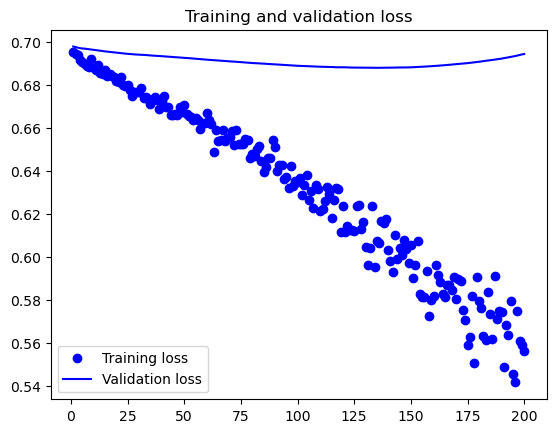

In [ ]:
# To plot the results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('test_results_acc.png')

plt.close()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('test_results_loss.png')
